<a href="https://colab.research.google.com/github/letianzj/QuantResearch/blob/master/notebooks/ch1_pca_relative_value.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Yield Curve PCA

There are three basic movements in yield curve: 
1. level or a parallel shift; 
2. slope, i.e., a flattening or steepening; and 
3. curvature, i.e., hump or butterfly.

PCA formalizes this viewpoint.

PCA can be applied to:
1. trade screening and construction;
2. risk assessment and return attribution;
3. scenarios analysis;
4. curve-neutral hedge.

* Accompanying notebook for [Chapter One](https://letianzj.gitbook.io/systematic-investing/products_and_methodologies/fixed_income)
* comments are placed below the cell.

## 1. Data preparation

In [1]:
%matplotlib inline
import os
import io
import time
from datetime import date, datetime, timedelta
import pandas as pd
import numpy as np
import scipy
import pandas_datareader.data as pdr
from pandas_datareader.fred import FredReader
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# download CMT treasury curves from Fred
codes = ['DGS1MO', 'DGS3MO', 'DGS6MO', 'DGS1', 'DGS2', 'DGS3', 'DGS5', 'DGS7', 'DGS10', 'DGS20', 'DGS30']
start_date = datetime(2000, 1, 1)
# end_date = datetime.today()
end_date = datetime(2020,12,31)
df = pd.DataFrame()

for code in codes:
    reader = FredReader(code, start_date, end_date)
    df0 = reader.read()
    df = df.merge(df0, how='outer', left_index=True, right_index=True, sort=False)
    reader.close()
df.dropna(axis = 0, inplace = True)
df = df['2006':]

In [3]:
df.tail(5)

,DGS1MO,DGS3MO,DGS6MO,DGS1,DGS2,DGS3,DGS5,DGS7,DGS10,DGS20,DGS30
DATE,,,,,,,,,,,
2020-12-24,0.09,0.09,0.09,0.10,0.13,0.17,0.37,0.66,0.94,1.46,1.66
2020-12-28,0.09,0.11,0.11,0.11,0.13,0.17,0.38,0.65,0.94,1.46,1.67
2020-12-29,0.08,0.10,0.12,0.11,0.12,0.17,0.37,0.66,0.94,1.47,1.67
2020-12-30,0.06,0.08,0.09,0.12,0.12,0.17,0.37,0.66,0.93,1.46,1.66
2020-12-31,0.08,0.09,0.09,0.10,0.13,0.17,0.36,0.65,0.93,1.45,1.65


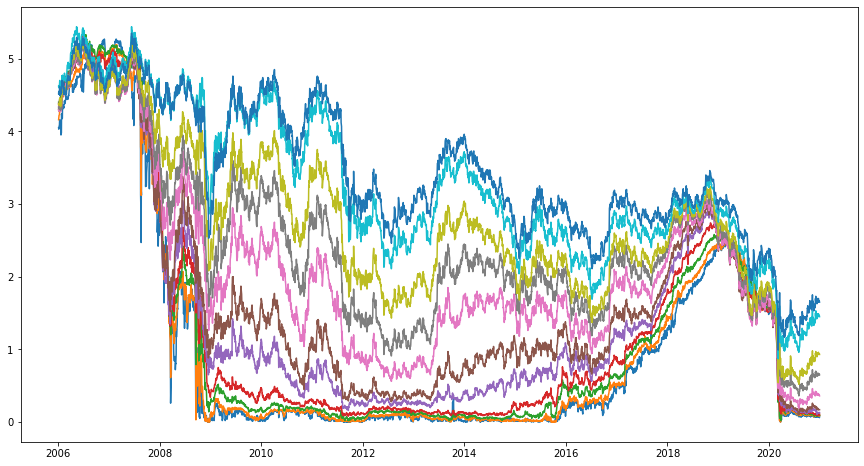

In [4]:
# view the yield curve
plt.figure(figsize=(15,8))
plt.plot(df)
plt.show()

In [5]:
# correlation among tenors
# sns.pairplot(df)

In [6]:
df_weekly = df.resample("W").last()
df_weekly.tail()

,DGS1MO,DGS3MO,DGS6MO,DGS1,DGS2,DGS3,DGS5,DGS7,DGS10,DGS20,DGS30
DATE,,,,,,,,,,,
2020-12-06,0.07,0.09,0.10,0.11,0.16,0.21,0.42,0.70,0.97,1.53,1.73
2020-12-13,0.08,0.08,0.08,0.10,0.11,0.18,0.37,0.63,0.90,1.42,1.63
2020-12-20,0.08,0.08,0.09,0.09,0.13,0.19,0.39,0.67,0.95,1.49,1.70
2020-12-27,0.09,0.09,0.09,0.10,0.13,0.17,0.37,0.66,0.94,1.46,1.66
2021-01-03,0.08,0.09,0.09,0.10,0.13,0.17,0.36,0.65,0.93,1.45,1.65


In [7]:
df_weekly_centered = df_weekly.sub(df_weekly.mean())
df_weekly_diff = df_weekly.diff()
df_weekly_diff.dropna(inplace=True)
df_weekly_diff_centered = df_weekly_diff.sub(df_weekly_diff.mean())
df_weekly.shape, df_weekly_diff.shape

((783, 11), (782, 11))

In [8]:
# covariance
df_weekly_diff.cov()

,DGS1MO,DGS3MO,DGS6MO,DGS1,DGS2,DGS3,DGS5,DGS7,DGS10,DGS20,DGS30
DGS1MO,0.019167,0.009983,0.005387,0.004291,0.002334,0.002013,0.001763,0.001464,0.001069,0.000743,0.000696
DGS3MO,0.009983,0.008384,0.005527,0.004424,0.002884,0.002720,0.002451,0.002156,0.001813,0.001555,0.001518
DGS6MO,0.005387,0.005527,0.005567,0.004776,0.003786,0.003731,0.003562,0.003250,0.002860,0.002409,0.002357
DGS1,0.004291,0.004424,0.004776,0.005399,0.004988,0.005119,0.005011,0.004647,0.004017,0.003413,0.003212
DGS2,0.002334,0.002884,0.003786,0.004988,0.008068,0.008559,0.008978,0.008454,0.007353,0.006143,0.005593
DGS3,0.002013,0.002720,0.003731,0.005119,0.008559,0.009975,0.010819,0.010533,0.009381,0.008055,0.007361
DGS5,0.001763,0.002451,0.003562,0.005011,0.008978,0.010819,0.013197,0.013420,0.012291,0.010856,0.009954
DGS7,0.001464,0.002156,0.003250,0.004647,0.008454,0.010533,0.013420,0.014472,0.013601,0.012373,0.011495
DGS10,0.001069,0.001813,0.002860,0.004017,0.007353,0.009381,0.012291,0.013601,0.013574,0.012874,0.012209
DGS20,0.000743,0.001555,0.002409,0.003413,0.006143,0.008055,0.010856,0.012373,0.012874,0.013275,0.012838


In [9]:
# correlation
df_weekly_diff.corr()

,DGS1MO,DGS3MO,DGS6MO,DGS1,DGS2,DGS3,DGS5,DGS7,DGS10,DGS20,DGS30
DGS1MO,1.000000,0.787477,0.521479,0.421829,0.187672,0.145546,0.110822,0.087923,0.066302,0.046598,0.044286
DGS3MO,0.787477,1.000000,0.809054,0.657596,0.350641,0.297437,0.233021,0.195709,0.169904,0.147428,0.145992
DGS6MO,0.521479,0.809054,1.000000,0.871084,0.564924,0.500653,0.415533,0.362070,0.329003,0.280243,0.278255
DGS1,0.421829,0.657596,0.871084,1.000000,0.755684,0.697445,0.593618,0.525682,0.469193,0.403153,0.384966
DGS2,0.187672,0.350641,0.564924,0.755684,1.000000,0.954097,0.870061,0.782327,0.702655,0.593566,0.548509
DGS3,0.145546,0.297437,0.500653,0.697445,0.954097,1.000000,0.942980,0.876639,0.806219,0.699992,0.649128
DGS5,0.110822,0.233021,0.415533,0.593618,0.870061,0.942980,1.000000,0.971078,0.918296,0.820225,0.763211
DGS7,0.087923,0.195709,0.362070,0.525682,0.782327,0.876639,0.971078,1.000000,0.970365,0.892653,0.841632
DGS10,0.066302,0.169904,0.329003,0.469193,0.702655,0.806219,0.918296,0.970365,1.000000,0.959046,0.923016
DGS20,0.046598,0.147428,0.280243,0.403153,0.593566,0.699992,0.820225,0.892653,0.959046,1.000000,0.981467


Correlation looks reasonable. The further apart between two tenors, the lower their correlation would be.

## 2. Fit PCA

In [10]:
# PCA fit
from sklearn.decomposition import PCA
pca_level = PCA().fit(df_weekly)        # call fit or fit_transform
pca_change = PCA().fit(df_weekly_diff)

Level is used to find the trading signals; change is used to find weights (hedge ratios).

In [11]:
print(pca_change.explained_variance_)        # eigenvalues
print(pca_change.explained_variance_ratio_)     # normalized eigenvalues (sum to 1)
print(np.cumsum(pca_change.explained_variance_ratio_))

[0.07872586 0.02802428 0.00926885 0.00443283 0.00143389 0.00093625
 0.00040641 0.00027666 0.0002018  0.00015337 0.00010808]
[0.63504845 0.22606011 0.07476791 0.03575777 0.01156656 0.00755236
 0.00327831 0.0022317  0.00162784 0.00123718 0.00087184]
[0.63504845 0.86110855 0.93587647 0.97163423 0.98320079 0.99075314
 0.99403145 0.99626315 0.99789099 0.99912816 1.        ]


Text(0, 0.5, 'cumulative explained variance')

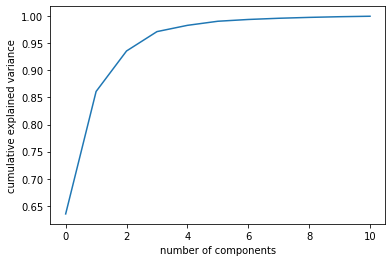

In [12]:
plt.plot(pca_change.explained_variance_ratio_.cumsum())
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

The first three PCA explain 93.59% of the total variance. This is slightly lower than some published papers where the number is above 95%.

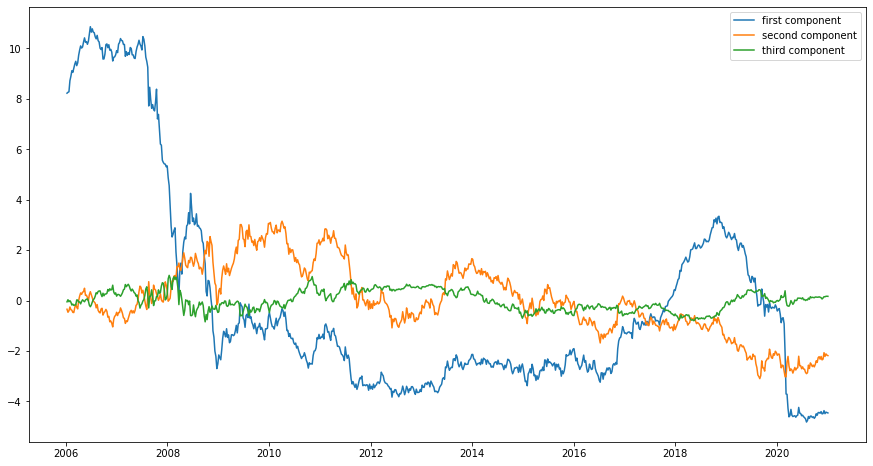

In [13]:
df_pca_level = pca_level.transform(df_weekly)            # T or PCs
df_pca_level = pd.DataFrame(df_pca_level, columns=[f'PCA_{x+1}' for x in range(df_pca_level.shape[1])])  # np.array to dataframe
df_pca_level.index = df_weekly.index
plt.figure(figsize=(15,8))
plt.plot(df_pca_level['PCA_1'], label='first component')
plt.plot(df_pca_level['PCA_2'], label='second component')
plt.plot(df_pca_level['PCA_3'], label='third component')
plt.legend()
plt.show()

The first PC is at its lower bound; second PC is bouncing back; third PC is trending towards its upper bound.

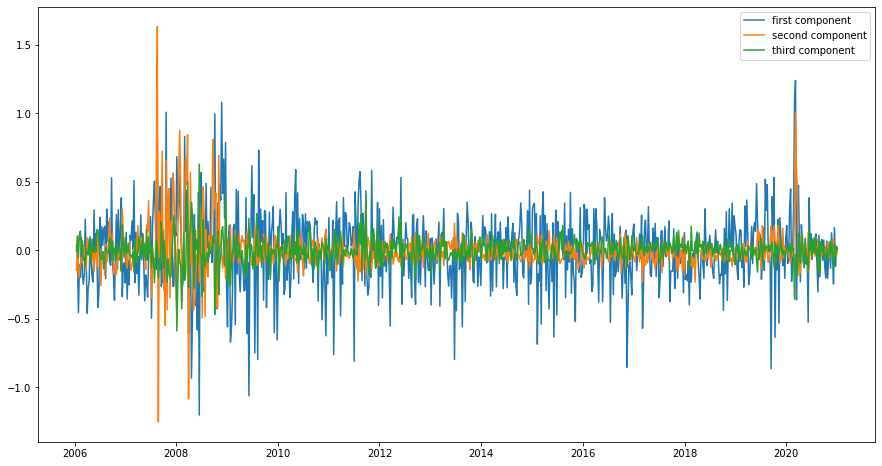

In [14]:
df_pca_change = pca_change.transform(df_weekly_diff)             # T or PCs
df_pca_change = pd.DataFrame(df_pca_change, columns=[f'PCA_{x+1}' for x in range(df_pca_change.shape[1])])  # np.array to dataframe
df_pca_change.index = df_weekly_diff.index
plt.figure(figsize=(15,8))
plt.plot(df_pca_change['PCA_1'], label='first component')
plt.plot(df_pca_change['PCA_2'], label='second component')
plt.plot(df_pca_change['PCA_3'], label='third component')
plt.legend()
plt.show()

On average, the first PC has the largest weekly changes; the second PC has the largest spike in late 2007. The third PC changes are relatively smaller. This is in line with the fact that first PC explains the highest variation.

In [15]:
print(pca_change.singular_values_.shape)        # SVD singular values of sigma
print(pca_change.get_covariance().shape)       # covariance
print(pca_change.components_.shape)         # p*p, W^T

(11,)
(11, 11)
(11, 11)


SVD has p singular values; covariance matrix is pxp. $W^T$ is pca.components_, which is pxp

In [16]:
print(pca_level.components_.T[:5, :5])
print(pca_change.components_.T[:5, :5])

[[ 0.36023252 -0.25655937  0.39913189 -0.56723613  0.01482805]
 [ 0.36796015 -0.24666686  0.29225917 -0.13972673 -0.01300978]
 [ 0.374633   -0.22942481  0.16101634  0.26181778  0.13081354]
 [ 0.36507482 -0.19841834 -0.02053929  0.45741015  0.04709652]
 [ 0.33890817 -0.10331612 -0.29148257  0.31022718 -0.21836308]]
[[-0.10250026 -0.75712007 -0.37420159 -0.4478502   0.20599242]
 [-0.11200385 -0.47010396 -0.00867281  0.34676659 -0.4662093 ]
 [-0.13449477 -0.28349481  0.20771456  0.51845356 -0.11134675]
 [-0.17040677 -0.21223415  0.29967192  0.3449688   0.28172845]
 [-0.26827879 -0.06440793  0.43679404 -0.12325569  0.40230782]]


Usually PCA on level and PCA on change give different results/weights.

In [17]:
print(df_pca_change.iloc[:5,:5])    # df_pca: T = centered(X) * W
print(np.matmul(df_weekly_diff_centered, pca_change.components_.T).iloc[:5, :5])     # XW

               PCA_1     PCA_2     PCA_3     PCA_4     PCA_5
DATE                                                        
2006-01-15  0.037659 -0.145471 -0.003422  0.042814 -0.042772
2006-01-22 -0.071417  0.107283  0.099630  0.122137 -0.022446
2006-01-29 -0.453613 -0.196927 -0.054567 -0.039250  0.059868
2006-02-05 -0.106102 -0.164901  0.114008 -0.047069  0.007816
2006-02-12 -0.196248 -0.097897  0.140442 -0.034231 -0.024348
              DGS1MO    DGS3MO    DGS6MO      DGS1      DGS2
DATE                                                        
2006-01-15  0.037659 -0.145471 -0.003422  0.042814 -0.042772
2006-01-22 -0.071417  0.107283  0.099630  0.122137 -0.022446
2006-01-29 -0.453613 -0.196927 -0.054567 -0.039250  0.059868
2006-02-05 -0.106102 -0.164901  0.114008 -0.047069  0.007816
2006-02-12 -0.196248 -0.097897  0.140442 -0.034231 -0.024348


The transform() output is T, or the first dataframe. Each volume is an eigenvector of covariance matrix $X^TX$.

The second dataframe should match the first, or $T=XW$. Here the input data X is centered but not scaled before applying SVD. W is pca.components_.T

In [18]:
np.matmul(pca_change.components_, pca_change.components_.T)[1,1], np.matmul(pca_change.components_.T, pca_change.components_)[1,1]

(1.0000000000000016, 0.9999999999999998)

Eigenvector W^T is unitary (wi and wj are orthogonal)

In [19]:
print(pca_change.explained_variance_[0])      # eigenvalue
print(np.dot(np.dot(pca_change.components_[0,:].reshape(1, -1), df_weekly_diff.cov()), pca_change.components_[0,:].reshape(-1, 1)))     # W^T X^TX W = lambda
print(np.dot(pca_change.components_[0,:].reshape(1, -1), df_weekly_diff.cov()))        # Ax
print(pca_change.components_[0,:]*pca_change.explained_variance_[0])                  # lambda x

0.07872586495891083
[[0.07872586]]
[[-0.00806942 -0.0088176  -0.01058822 -0.01341542 -0.02112048 -0.02541622
  -0.03097223 -0.03273537 -0.03145325 -0.02949365 -0.0279408 ]]
[-0.00806942 -0.0088176  -0.01058822 -0.01341542 -0.02112048 -0.02541622
 -0.03097223 -0.03273537 -0.03145325 -0.02949365 -0.0279408 ]


It shows that the eigenvalues of $X^TX$ are explained variance. They represent the variance in the direction of the eigenvector. The second line is the calculated eigenvalue $\lambda$.

The third line calculates $AX$, and the last line calculates $\lambda x$, where $A=X^TX$. By definition, they should match.

In [20]:
df_pca_change_123 = PCA(n_components=3).fit_transform(df_weekly_diff)     
df_pca_change_123 = pd.DataFrame(data = df_pca_change_123, columns = ['first component', 'second component', 'third component'])
print(df_pca_change_123.head(5))
print(df_pca_change.iloc[:5, :3])

   first component  second component  third component
0         0.037659         -0.145471        -0.003422
1        -0.071417          0.107283         0.099630
2        -0.453613         -0.196927        -0.054567
3        -0.106102         -0.164901         0.114008
4        -0.196248         -0.097897         0.140442
               PCA_1     PCA_2     PCA_3
DATE                                    
2006-01-15  0.037659 -0.145471 -0.003422
2006-01-22 -0.071417  0.107283  0.099630
2006-01-29 -0.453613 -0.196927 -0.054567
2006-02-05 -0.106102 -0.164901  0.114008
2006-02-12 -0.196248 -0.097897  0.140442


Alternatively We can do fit_transform on one call. It should match the two-step fit and transform.

## 3. Curve Analysis

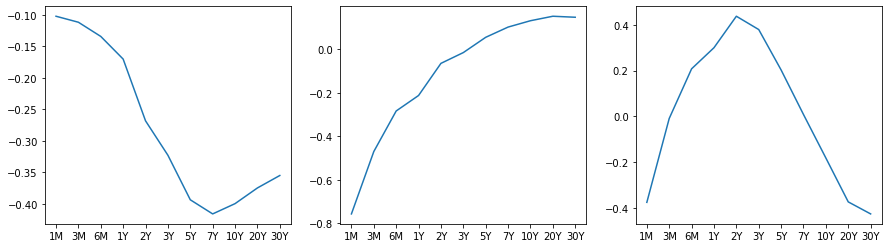

In [21]:
tenors_label = ['1M', '3M', '6M', '1Y', '2Y', '3Y', '5Y', '7Y', '10Y', '20Y', '30Y']
plt.figure(figsize=(15,4))
plt.subplot(131)
plt.plot(tenors_label, pca_change.components_[0, :])
plt.subplot(132)
plt.plot(tenors_label, pca_change.components_[1, :])
plt.subplot(133)
plt.plot(tenors_label, pca_change.components_[2, :])

**The first eigenvector (first column of W) is the exposure (factor loading) of X to the first rotated rates (first PCA factor, as the first column of T).**

Note that it takes first row of pca.components_ because of the W transpose.

First PC is level. All tenors shift down (negative) but long tenors move more than short tenors. The peak is at 7s. If the first pca moves up 1bps, all tenors move down. 1M moves down 0.10bps, 7Y moves down 0.40bps, 30Y moves down 0.35bps.

Second PC is spread. It suggests that short tenors move downward while long tenors move upward, or steepening. 

Third PC is butterfly or curvature. The belly rises 40bps while the wings fall 40bps.

In [22]:
T = np.matmul(df_weekly_diff_centered, pca_change.components_.T)     # T = XW
bump_up = np.zeros(T.shape[1]).reshape(1,-1)
bump_up[0,0] = 1        # first PC moves 1bps
bump_up = np.repeat(bump_up, T.shape[0], axis=0)
T_new = T+bump_up
df_weekly_diff_new = np.matmul(T_new, pca_change.components_)       # X_new = T_new * W^T
print((df_weekly_diff_new-df_weekly_diff_centered).head())          # X - X_new
print(pca_change.components_[0, :])

            DGS1MO    DGS3MO    DGS6MO  ...     DGS10     DGS20     DGS30
DATE                                    ...                              
2006-01-15 -0.1025 -0.112004 -0.134495  ... -0.399529 -0.374637 -0.354913
2006-01-22 -0.1025 -0.112004 -0.134495  ... -0.399529 -0.374637 -0.354913
2006-01-29 -0.1025 -0.112004 -0.134495  ... -0.399529 -0.374637 -0.354913
2006-02-05 -0.1025 -0.112004 -0.134495  ... -0.399529 -0.374637 -0.354913
2006-02-12 -0.1025 -0.112004 -0.134495  ... -0.399529 -0.374637 -0.354913

[5 rows x 11 columns]
[-0.10250026 -0.11200385 -0.13449477 -0.17040677 -0.26827879 -0.32284454
 -0.39341869 -0.41581462 -0.39952882 -0.37463736 -0.35491257]


To see why each column of W is the exposure, parallel shift first PC up by 1bps. Then for each tenor, the move is according to the factor exposure (two prints match).

## 4. Mean-reversion

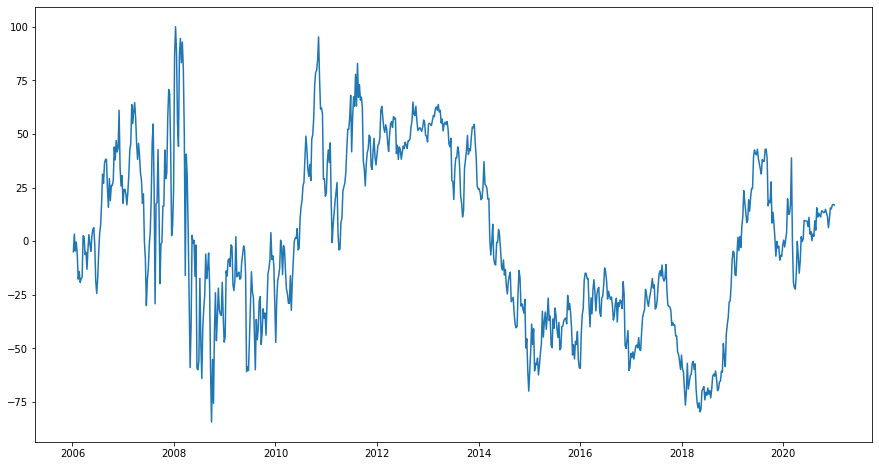

In [23]:
plt.figure(figsize=(15,8))
plt.plot(df_pca_level['PCA_3']*100, label='third component')

In [24]:
def mle(x):
  start = np.array([0.5, np.mean(x), np.std(x)])       # starting guess

  def error_fuc(params):
    theta = params[0]
    mu = params[1]
    sigma = params[2]

    muc = x[:-1]*np.exp(-theta) + mu*(1.0-np.exp(-theta))      # conditional mean
    sigmac = sigma*np.sqrt((1-np.exp(-2.0*theta))/(2*theta))     # conditional vol

    return -np.sum(scipy.stats.norm.logpdf(x[1:], loc=muc, scale=sigmac))

  result = scipy.optimize.minimize(error_fuc, start, method='L-BFGS-B',
                                     bounds=[(1e-6, None), (None, None), (1e-8, None)],
                                     options={'maxiter': 500, 'disp': False})
  return result.x

theta, mu, sigma  = mle(df_pca_level['PCA_3'])
print(theta, mu, sigma)
print(f'fly mean is {mu*100} bps')
print(f'half-life in week {np.log(2)/theta}')
print(f'annual standard deviation is {sigma/np.sqrt(2*theta)*100} bps, weekly {sigma/np.sqrt(2*theta)*100*np.sqrt(1/52)} bps')
print(np.mean(df_pca_change)[:3]*100, np.std(df_pca_change)[:3]*100)       # stats
print(df_pca_level['PCA_3'].tail(1)*100)      # current pca_3

0.04192451154834535 0.006565036501929492 0.11472812649582306
fly mean is 0.6565036501929492 bps
half-life in week 16.533220184584405
annual standard deviation is 39.62058631800509 bps, weekly 5.494386751289013 bps
PCA_1   -3.162210e-16
PCA_2    6.396516e-16
PCA_3   -6.544034e-17
dtype: float64 PCA_1    28.040184
PCA_2    16.729748
PCA_3     9.621329
dtype: float64
DATE
2021-01-03    16.783769
Freq: W-SUN, Name: PCA_3, dtype: float64


See Chapter Mean-reversion equation (A8) for the MLE expression.

The fly mean is 0.657bps, the weekly mean-reversion is 4.19bps, or half-life is 16 weeks. Weekly standard deviation is 5.5 bps. 

In comparison, the statistics show PCA_3 mean is 0 and std is 9.62bps.

## 5. Butterfly

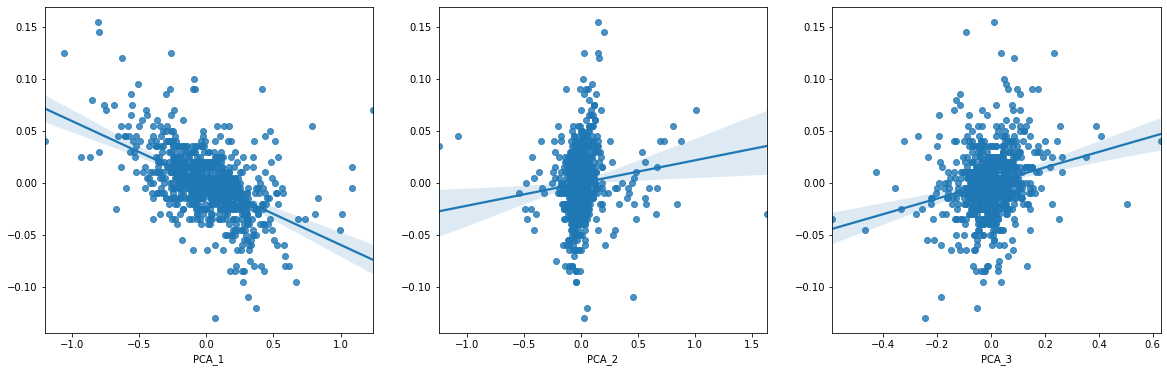

In [63]:
fly5050 = df_weekly_diff['DGS5'] - (df_weekly_diff['DGS2']+df_weekly_diff['DGS10'])/2
plt.figure(figsize=(20,6))
plt.subplot(131)
sns.regplot(x=df_pca_change['PCA_1'], y=fly5050)
plt.subplot(132)
sns.regplot(x=df_pca_change['PCA_2'], y=fly5050)
plt.subplot(133)
sns.regplot(x=df_pca_change['PCA_3'], y=fly5050)

This is 50-50 DV01 neutral fly. It is not market value neutral.

It has negative exposure to PC1 and positive exposure to PC2 (the linear regression coefficient is not zero).

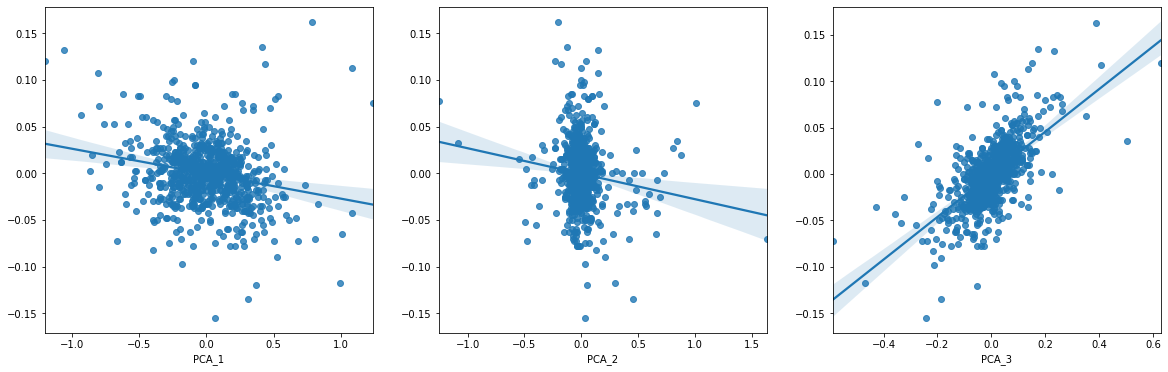

In [62]:
flymkt = df_weekly_diff['DGS5'] - (0.25*df_weekly_diff['DGS2']+0.75*df_weekly_diff['DGS10'])
plt.figure(figsize=(20,6))
plt.subplot(131)
sns.regplot(x=df_pca_change['PCA_1'], y=flymkt)
plt.subplot(132)
sns.regplot(x=df_pca_change['PCA_2'], y=flymkt)
plt.subplot(133)
sns.regplot(x=df_pca_change['PCA_3'], y=flymkt)

Assume 2s, 5s, 10s durations are 1.8, 4.5, and 9.0, respectively.

* The 50-50 DV01 neutral has DV01 weights 0.5-1.0-0.5, and market value 1.25mm-1mm-250k. It buys more 2s than 10s because of shorter duration. Buying fly pays 0.5mm upfront.

* The market neutral has market value 6.25k-1mm-375k; DV01 weights 0.25-1-0.75. In order to have zero upfront payment and zero DV01, it underweights (overweights) 2s (10s).

In [29]:
W = pd.DataFrame(pca_change.components_.T)
W.columns = [f'PCA_{i+1}' for i in range(W.shape[1])]
W.index = codes
w21 = W.loc['DGS2', 'PCA_1']
w22 = W.loc['DGS2', 'PCA_2']
w23 = W.loc['DGS2', 'PCA_3']

w51 = W.loc['DGS5', 'PCA_1']
w52 = W.loc['DGS5', 'PCA_2']
w53 = W.loc['DGS5', 'PCA_3']

w101 = W.loc['DGS10', 'PCA_1']
w102 = W.loc['DGS10', 'PCA_2']
w103 = W.loc['DGS10', 'PCA_3']

w551 = w51 - (w21+w101)/2.0
w552 = w52 - (w22+w102)/2.0
print(w551, w552)

-0.059514884305378046 0.021767823095657196


50-50 duration has non-zero exposures on PC1 and PC2

In [38]:
A = np.array([[w21, w101],[w22,w102]])
b_ = np.array([w51, w52])
a, b = np.dot(np.linalg.inv(A), b_)
a, b

(0.4859957458180909, 0.6583663710956328)

To immunize against first and second PCA, we solve DV01 a and b from the following

$$
w21*a - w51*1 + w101*b = 0 \\
w22*a - w52*1 + w102*b = 0
$$

By solving a and b, it gives DV01 0.486-1-0.658, or market value 1.215mm-1mm-329k.

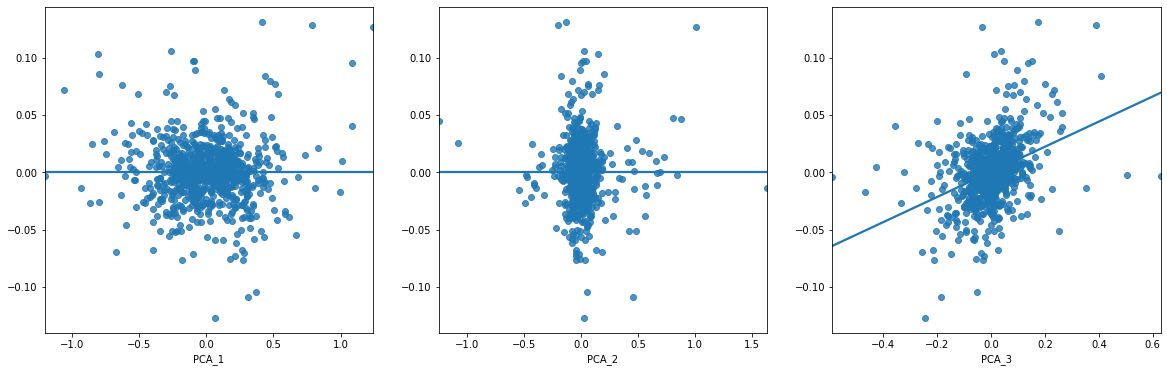

In [61]:
flypca = df_weekly_diff['DGS5']*1 - (a*df_weekly_diff['DGS2']+b*df_weekly_diff['DGS10'])
plt.figure(figsize=(20,6))
plt.subplot(131)
sns.regplot(x=df_pca_change['PCA_1'], y=flypca, ci=None)
plt.subplot(132)
sns.regplot(x=df_pca_change['PCA_2'], y=flypca, ci=None)
plt.subplot(133)
sns.regplot(x=df_pca_change['PCA_3'], y=flypca, ci=None)

PCA weighted fly has zero exposure to PC1 and PC2 (the line is horizontal).

slope 1: 1.1415520546405518e-16, 2: -1.3348731104241916e-16, 3: 0.10950726425130013


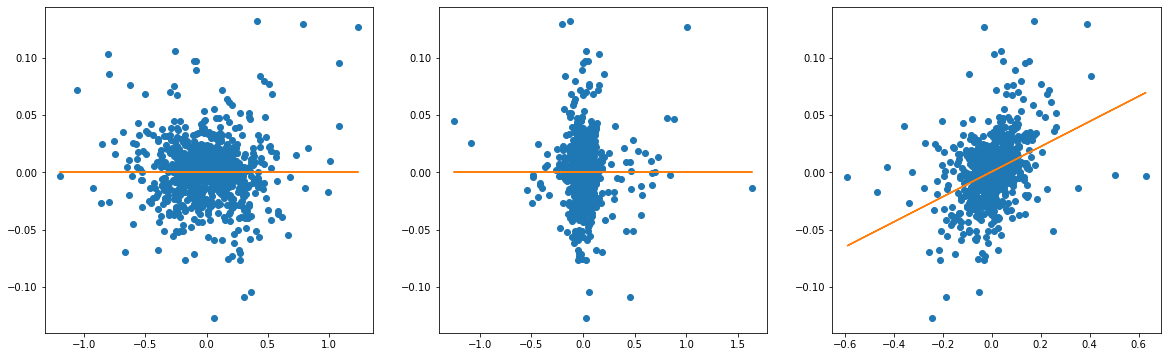

In [66]:
plt.figure(figsize=(20,6))
plt.subplot(131)
plt.plot(df_pca_change['PCA_1'], flypca, 'o')
m1, b1 = np.polyfit(df_pca_change['PCA_1'], flypca, 1)
plt.plot(df_pca_change['PCA_1'], m1*df_pca_change['PCA_1']+b1)
plt.subplot(132)
plt.plot(df_pca_change['PCA_2'], flypca, 'o')
m2, b2 = np.polyfit(df_pca_change['PCA_2'], flypca, 1)
plt.plot(df_pca_change['PCA_2'], m2*df_pca_change['PCA_2']+b2)
plt.subplot(133)
plt.plot(df_pca_change['PCA_3'], flypca, 'o')
m3, b3 = np.polyfit(df_pca_change['PCA_3'], flypca, 1)
plt.plot(df_pca_change['PCA_3'], m3*df_pca_change['PCA_3']+b3)
print(f'slope 1: {m1}, 2: {m2}, 3: {m3}')

This is an alternative plot via matplotlib, equivalent to the sns plot above. 

The print shows slopes are zero to PC1 and PC2.